In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.utils.class_weight import compute_class_weight

In [2]:
train = pd.read_csv('train_metadata.csv')
test = pd.read_csv('test_metadata.csv')

In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320847 entries, 0 to 320846
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           320847 non-null  int64  
 1   target                       320847 non-null  int64  
 2   age_approx                   318620 non-null  float64
 3   sex                          311621 non-null  object 
 4   anatom_site_general          316242 non-null  object 
 5   clin_size_long_diam_mm       320847 non-null  float64
 6   tbp_tile_type                320847 non-null  object 
 7   tbp_lv_A                     320847 non-null  float64
 8   tbp_lv_Aext                  320847 non-null  float64
 9   tbp_lv_B                     320847 non-null  float64
 10  tbp_lv_Bext                  320847 non-null  float64
 11  tbp_lv_C                     320847 non-null  float64
 12  tbp_lv_Cext                  320847 non-null  float64
 13 

In [4]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80212 entries, 0 to 80211
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           80212 non-null  int64  
 1   target                       0 non-null      float64
 2   age_approx                   79641 non-null  float64
 3   sex                          77921 non-null  object 
 4   anatom_site_general          79061 non-null  object 
 5   clin_size_long_diam_mm       80212 non-null  float64
 6   tbp_tile_type                80212 non-null  object 
 7   tbp_lv_A                     80212 non-null  float64
 8   tbp_lv_Aext                  80212 non-null  float64
 9   tbp_lv_B                     80212 non-null  float64
 10  tbp_lv_Bext                  80212 non-null  float64
 11  tbp_lv_C                     80212 non-null  float64
 12  tbp_lv_Cext                  80212 non-null  float64
 13  tbp_lv_H        

In [5]:
#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(train.target.value_counts(normalize=True)*100)



Class Distribution Before Sampling (%):


target
0    99.902134
1     0.097866
Name: proportion, dtype: float64

In [6]:
seed = 1 # controllable randomness
neg_sample = .01  
pos_sample = 5.0

# Sampling
positive_df = train.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = train.query("target==1").sample(frac=pos_sample, replace=True, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Distribution After Sampling (%):


target
0    67.120419
1    32.879581
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.7449297971918877), 1: np.float64(1.5207006369426752)}


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4775 entries, 58910 to 217877
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           4775 non-null   int64  
 1   target                       4775 non-null   int64  
 2   age_approx                   4749 non-null   float64
 3   sex                          4637 non-null   object 
 4   anatom_site_general          4721 non-null   object 
 5   clin_size_long_diam_mm       4775 non-null   float64
 6   tbp_tile_type                4775 non-null   object 
 7   tbp_lv_A                     4775 non-null   float64
 8   tbp_lv_Aext                  4775 non-null   float64
 9   tbp_lv_B                     4775 non-null   float64
 10  tbp_lv_Bext                  4775 non-null   float64
 11  tbp_lv_C                     4775 non-null   float64
 12  tbp_lv_Cext                  4775 non-null   float64
 13  tbp_lv_H         

In [8]:
from sklearn.model_selection import StratifiedGroupKFold

#training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r') # this is gone now since we have a bunch of images

# Reset index to ensure a continuous index
df = df.reset_index(drop=True)
df["fold"] = -1

# Set up the StratifiedGroupKFold with 4 splits
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.id)):
    df.loc[validation_idx, "fold"] = int(i)


df.to_csv("folds.csv", index=False)


In [9]:
#print id column in df to csv
df['id'].to_csv('id.csv', index=False)


In [10]:
df.shape

(4775, 42)

In [11]:
y = df["target"]

In [12]:
test.shape

(80212, 41)

Test has fewer columns than train - only use the intersection so that we can apply to test data <br>

In [13]:
shared_cols = set(df.columns).intersection(set(test.columns))
len(shared_cols)

41

Use second line in the next cell if you want to use all columns instead.

In [14]:
# train_trim = train[list(shared_cols)]
train_trim = df.drop("target", axis=1)
train_trim.shape

(4775, 41)

String columns

In [15]:
len(train_trim.select_dtypes(include="object").columns)

5

Number columns

In [16]:
len(train_trim.select_dtypes(include="number").columns)

36

Null checking

In [17]:
nulls = train_trim.apply(lambda col: col.isnull().sum() / col.size * 100)
nulls.head()

id                        0.000000
age_approx                0.544503
sex                       2.890052
anatom_site_general       1.130890
clin_size_long_diam_mm    0.000000
dtype: float64

Columns with nulls

In [18]:
nulls[nulls > 0]

age_approx             0.544503
sex                    2.890052
anatom_site_general    1.130890
dtype: float64

Coalescing rows with no age. Sex handled later, anatom_site_general not used.

In [19]:
#coalsece the nulls with the mean
train_trim["age_approx"] = train_trim["age_approx"].fillna(train_trim["age_approx"].mean())

Extract string columns

In [20]:
string_cols = train_trim.select_dtypes(include="object")
string_cols.head()

,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple
0,male,posterior torso,3D: XP,Torso Back Top Third,Torso Back
1,male,posterior torso,3D: white,Torso Back Middle Third,Torso Back
2,male,posterior torso,3D: white,Torso Back Top Third,Torso Back
3,male,head/neck,3D: white,Head & Neck,Head & Neck
4,male,upper extremity,3D: XP,Right Arm - Lower,Right Arm


Check for constant-value columns

In [21]:
string_cols.apply(lambda row: row.unique())

sex                                                     [male, female, nan]
anatom_site_general       [posterior torso, head/neck, upper extremity, ...
tbp_tile_type                                           [3D: XP, 3D: white]
tbp_lv_location           [Torso Back Top Third, Torso Back Middle Third...
tbp_lv_location_simple    [Torso Back, Head & Neck, Right Arm, Left Leg,...
dtype: object

Drop ID and other useless string columns

In [22]:
to_drop = ["tbp_tile_type", "copyright_license", "isic_id", "patient_id", "attribution", "image_type"]
set(string_cols.columns).difference(set(to_drop))

{'anatom_site_general', 'sex', 'tbp_lv_location', 'tbp_lv_location_simple'}

3 location columns, increasing specificity. Using the middle one for one-hot encoding

In [23]:
string_cols["anatom_site_general"].value_counts()

anatom_site_general
posterior torso    1347
lower extremity    1092
anterior torso     1067
upper extremity     808
head/neck           407
Name: count, dtype: int64

In [24]:
string_cols["tbp_lv_location_simple"].value_counts()

tbp_lv_location_simple
Torso Back     1347
Torso Front    1067
Left Leg        582
Right Leg       510
Left Arm        445
Head & Neck     407
Right Arm       363
Unknown          54
Name: count, dtype: int64

In [25]:
string_cols["tbp_lv_location"].value_counts()

tbp_lv_location
Torso Front Top Half       810
Torso Back Top Third       800
Torso Back Middle Third    489
Head & Neck                407
Left Leg - Lower           294
Right Leg - Lower          287
Left Arm - Upper           273
Torso Front Bottom Half    257
Right Arm - Upper          253
Left Leg - Upper           248
Right Leg - Upper          202
Left Arm - Lower           148
Right Arm - Lower          107
Torso Back Bottom Third     58
Unknown                     54
Left Leg                    40
Left Arm                    24
Right Leg                   21
Right Arm                    3
Name: count, dtype: int64

One-hot encoding the sex column. Using a vector of length 2 here to account for the NaaNs - when the value is "unknown", the vector is [0, 0]. Alternatively, we could drop all NaaN rows and use a single indicator column.

In [26]:
male_indicator = string_cols["sex"].apply(lambda s: int(s == "male" and not s == "unknown"))
male_indicator.name = "Male"
female_indicator = string_cols["sex"].apply(lambda s: int(s == "female" and not s == "unknown"))
female_indicator.name = "Female"

In [27]:
numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
numerical_sex.tail()

,Male,Female
4770,0,1
4771,1,0
4772,1,0
4773,1,0
4774,0,1


One-hot encoding the location column

In [28]:
one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: int(loc == location))).transpose()
one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
one_hot_location.head()


tbp_lv_location_simple,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Head & Neck,Right Arm
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1


Total one-hot encoded columns

In [29]:
one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
one_hot_combined.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Head & Neck,Right Arm
0,1,0,1,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1


Normalizing other numerical columns to the [0, 1] range with min-max scaling

In [30]:
numerical = train_trim.select_dtypes(include="number")
#normalize all the numerical columns except fold

for column in numerical.columns:
    if column != "fold":
        numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())  

Concat with numerical columns to get the clean data

In [31]:
clean = pd.concat([one_hot_combined, numerical], axis=1)
clean.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Head & Neck,Right Arm,id,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,fold
0,1,0,1,0,0,0,0,0,0,0.183553,...,0.114534,0.213117,0.089611,0.104561,0.260074,0.828571,0.508827,0.868698,0.859981,2
1,1,0,1,0,0,0,0,0,0,0.354840,...,0.046411,0.000000,0.043121,0.088989,0.404579,0.314286,0.363522,0.705062,0.773890,4
2,1,0,1,0,0,0,0,0,0,0.295628,...,0.084933,0.190001,0.134635,0.094890,0.139768,0.571429,0.511961,0.821222,0.671056,3
3,1,0,0,0,0,0,0,1,0,0.950875,...,0.178536,0.345095,0.257933,0.147470,0.451840,0.714286,0.471329,0.894031,0.209891,0
4,1,0,0,0,0,0,0,0,1,0.879590,...,0.022992,0.000000,0.065485,0.118731,0.295905,0.628571,0.846082,0.744215,0.529914,2


In [32]:
clean.columns

Index(['Male', 'Female', 'Torso Back', 'Torso Front', 'Left Leg', 'Right Leg',
       'Left Arm', 'Head & Neck', 'Right Arm', 'id', 'age_approx',
       'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
       'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
       'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
       'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'fold'],
      dtype='object')

Save the clean data

In [33]:
# clean.to_csv("../../../clean_train-metadata.csv", index=False)

In [34]:
y = y[clean.index]

Fold 0 - AUROC: 0.8343
Fold 0 has the best AUROC so far: 0.8343
Fold 1 - AUROC: 0.8151
Fold 2 - AUROC: 0.7986
Fold 3 - AUROC: 0.8747
Fold 3 has the best AUROC so far: 0.8747
Fold 4 - AUROC: 0.7671
Best probabilities saved to 'best_tabular_fold_probabilities.csv' with AUROC: 0.8747
Best fold: 3


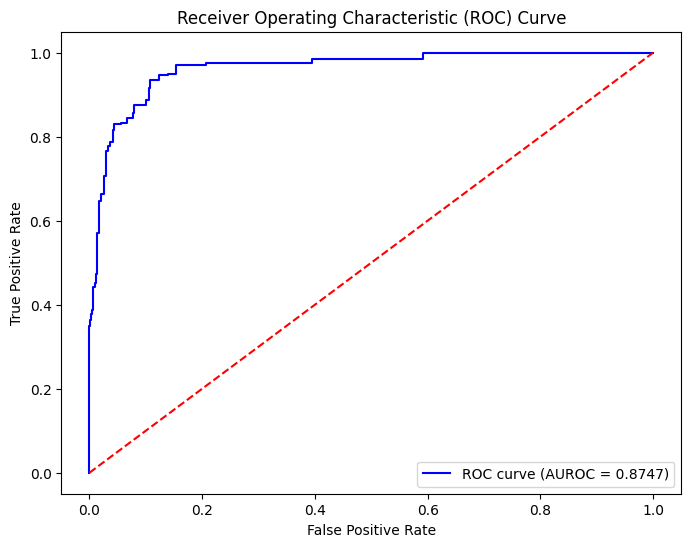

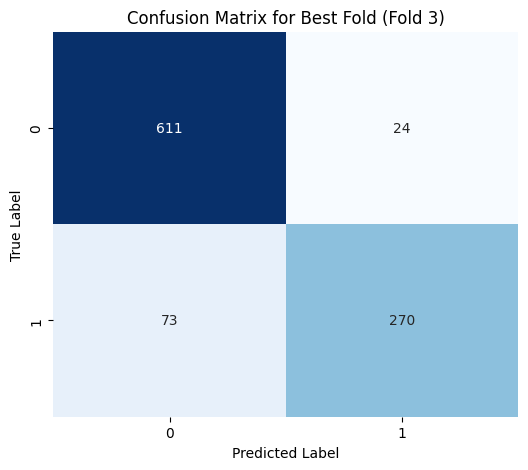

In [35]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

num_parallel_tree = 4
num_boost_round = 16
best_auc = 0
best_probabilities_df = None
best_fold = -1
best_y_test = None
best_predicted_labels = None
best_probabilities_df_train = None

for i in range(5):
    # Split data into training and test sets
    X_train = clean[clean["fold"] != i]
    y_train = y[clean["fold"] != i]
    X_train = X_train.drop("fold", axis=1)

    X_test = clean[clean["fold"] == i]
    y_test = y[clean["fold"] == i]
    X_test = X_test.drop("fold", axis=1)

    # Prepare DMatrix
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)

    # Train model
    booster = xgb.train({
        'num_parallel_tree': num_parallel_tree,
        'subsample': 0.5,
        'num_class': 2,  # Specify the number of classes
        'objective': 'multi:softprob',  # Multiclass probabilities
        'seed': 1
    }, dtrain, num_boost_round=num_boost_round)

    # Get probabilities
    fold_probabilities = booster.predict(dtest)  # Each row contains probabilities for all classes
    fold_probabilities_train = booster.predict(dtrain)  # Each row contains probabilities for all classes

    # Store probabilities and true labels
    probability_columns = [f"prob_class_{j}" for j in range(2)]  # Replace '2' with the number of classes
    fold_probabilities_df = pd.DataFrame(fold_probabilities, columns=probability_columns)

    probability_columns_train = [f"prob_class_{j}" for j in range(2)]  # Replace '2' with the number of classes
    fold_probabilities_df_train = pd.DataFrame(fold_probabilities_train, columns=probability_columns_train)

    # Pick class that has the highest probability
    fold_probabilities_df["predicted_label"] = fold_probabilities_df[["prob_class_0", "prob_class_1"]].idxmax(axis=1).map({"prob_class_0": 0, "prob_class_1": 1})

    fold_probabilities_df_train["predicted_label"] = fold_probabilities_df_train[["prob_class_0", "prob_class_1"]].idxmax(axis=1).map({"prob_class_0": 0, "prob_class_1": 1})

    # Calculate AUROC for this fold
    auc = roc_auc_score(y_test, fold_probabilities_df["predicted_label"])
    print(f"Fold {i} - AUROC: {auc:.4f}")

    # Check if this is the best fold
    if auc > best_auc:
        best_auc = auc
        best_probabilities_df = fold_probabilities_df["prob_class_1"]
        best_y_test = y_test
        best_predicted_labels = fold_probabilities_df["predicted_label"]
        best_fold = i
        best_probabilities_df_train = fold_probabilities_df_train["prob_class_1"]
        print(f"Fold {i} has the best AUROC so far: {best_auc:.4f}")

# Save the best fold's probabilities to a CSV file
if best_probabilities_df is not None:
    # Rename this column to target
    best_probabilities_df = best_probabilities_df.rename("target")
    best_probabilities_df.to_csv("best_tabular_fold_probabilities.csv", index=False)
    best_probabilities_df_train = best_probabilities_df_train.rename("target")
    best_probabilities_df_train.to_csv("best_tabular_fold_probabilities_train.csv", index=False)
    print(f"Best probabilities saved to 'best_tabular_fold_probabilities.csv' with AUROC: {best_auc:.4f}")
    print(f"Best fold: {best_fold}")

    # Plot ROC curve for the best model
    fpr, tpr, thresholds = roc_curve(best_y_test, best_probabilities_df)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUROC = {best_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion matrix for the best fold
    cm = confusion_matrix(best_y_test, best_predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Best Fold (Fold {best_fold})')
    plt.show()

else:
    print("No valid folds found.")
